This notebook has to be run on Google colab, for the GPU use.

You also need to clone the [MUSE](https://github.com/facebookresearch/MUSE) repository.

In [ ]:
from scipy import spatial
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/MUSE

/content/drive/MyDrive/MUSE


In [ ]:
!pip install faiss-gpu --no-cache

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 219.3 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/deepmipt/fastText.git#egg=fastText==0.8.22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmipt/fastText.git to /tmp/pip-install-q82vu837/fasttext_a8b97d6e74424a878a973181e1e0d6d1
  Running command git clone --filter=blob:none --quiet https://github.com/deepmipt/fastText.git /tmp/pip-install-q82vu837/fasttext_a8b97d6e74424a878a973181e1e0d6d1
  Resolved https://github.com/deepmipt/fastText.git to commit 206f6e2f98ee9fe7288acd6a9a2fa2e381299ccd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 11.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fastText
  Running setup.py clean for fastText
Failed to build fastText
  Running setup.py install for fastText ... done


In [ ]:
# Uncomment this next lign to perform the alignment
# The data comes from the MUSE project
#!python supervised.py --src_lang fr --tgt_lang en --src_emb ../data/fr_model.bin --tgt_emb ../data/en_model.bin --n_refinement 5 --dico_train default --emb_dim 100 --dico_train data/fr-en.0-5000.txt --dico_eval data/fr-en.5000-6500.txt

**2. Visualize**

In [ ]:
import io
import numpy as np

def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [ ]:
embeddings_fr, id2word_fr, word2id_fr = load_vec("./dumped/debug/g3n9myrpjg/vectors-fr.txt")
embeddings_en, id2word_en, word2id_en = load_vec("./dumped/debug/g3n9myrpjg/vectors-en.txt")

In [ ]:
import matplotlib.pyplot as plt
from random import random
def plot_similar_word(topics_df, src_word2id, src_emb, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    word_marker = []
    word_color = []

    for topic in topics_df.iterrows():
       #color = (random(), random(), random())
       for w in to_list(topic[1]):
         try:
            if topic[1]["country"] == "us":
              Y.append(tgt_emb[tgt_word2id[w]])
              word_marker.append("x")
              word_color.append((0,0,1))
            else:
              Y.append(src_emb[src_word2id[w]])
              word_marker.append("o")
              word_color.append((1,0,0))
            word_labels.append(w)
            #word_color.append(color)
         except: 
            pass

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(15, 15), dpi=80)

    plt.scatter(Y[:word_marker.count('x'), 0], Y[:word_marker.count('x'), 1], marker='x')
    plt.scatter(Y[word_marker.count('o'):, 0], Y[word_marker.count('o'):, 1], marker='o')

    for k, (label, color, x, y) in enumerate(zip(word_labels, word_color, x_coords, y_coords)):
        #color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color)

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')
    plt.savefig('viz.png')
    plt.show()


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([embeddings_fr, embeddings_en]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.12


In [ ]:
import pandas as pd
topics_df = pd.read_csv("./data/topics_df.csv")

In [ ]:
to_list = lambda l : l.topic.replace("[", "").replace("]", "").replace("\'", "").split(", ")

In [ ]:
time_period_df = topics_df[topics_df["period"]=="1870-1880"]
topics_viz = time_period_df[time_period_df["topic_id"]=="1870-1880_telegraph_fr_13"] #elections
topics_viz = topics_viz.append(time_period_df[time_period_df["topic_id"]=="1870-1880_coal_fr_24"]) #miners
topics_viz = topics_viz.append(time_period_df[time_period_df["topic_id"]=="1870-1880_telegraph_fr_15"]) #war
topics_viz = topics_viz.append(time_period_df[time_period_df["topic_id"]=="1870-1880_coal_us_12"]) #miners
topics_viz = topics_viz.append(time_period_df[time_period_df["topic_id"]=="1870-1880_elec_us_11"]) #elections
topics_viz = topics_viz.append(time_period_df[time_period_df["topic_id"]=="1870-1880_telegraph_us_9"]) #war

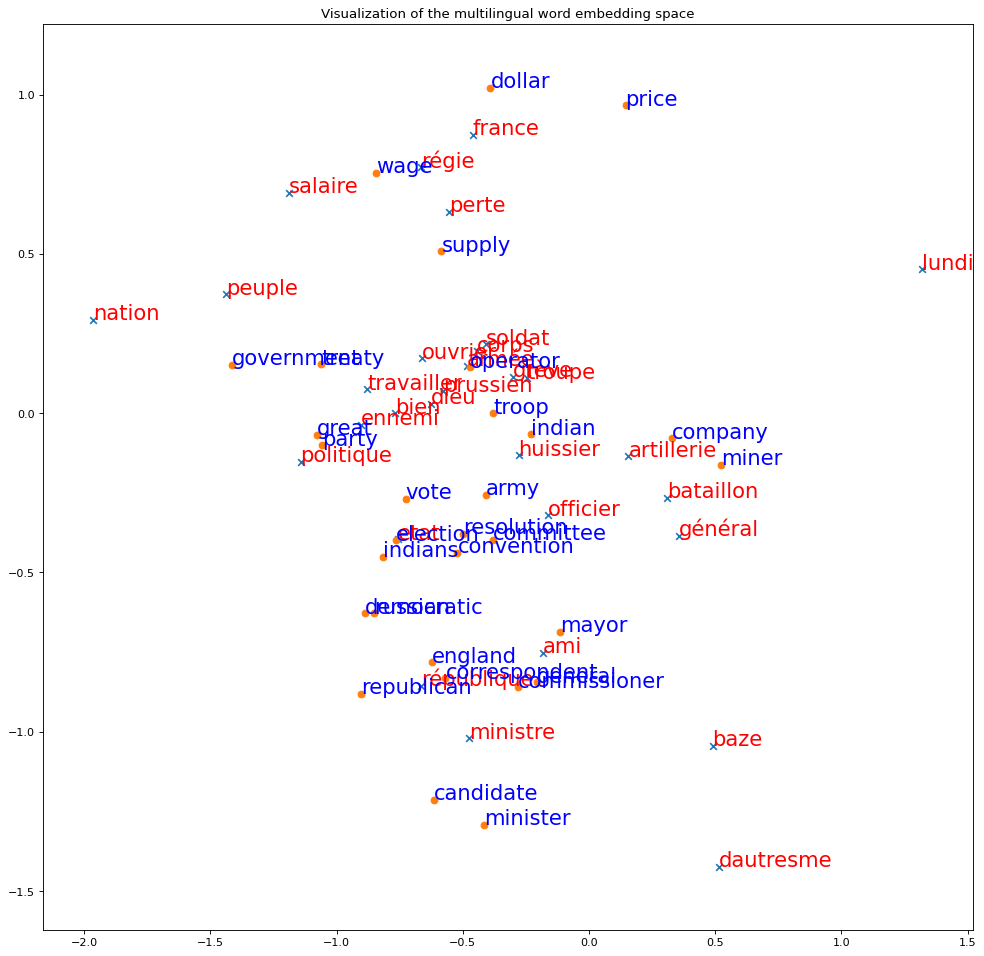

In [ ]:
time_period_df = topics_df[topics_df["period"]=="1870-1880"]
us_fr_df = time_period_df[time_period_df["country"]=="us"].sample(3).append(time_period_df[time_period_df["country"]=="fr"].sample(3))
plot_similar_word(topics_viz, word2id_fr, embeddings_fr, word2id_en, embeddings_en, pca)

In [ ]:
reduced_emb = []
reduced_word2id = dict()
idx = 0
for t in topics_df[topics_df["country"]=="fr"].iterrows():
    for w in to_list(t[1]):
       if w in word2id_fr.keys():
          reduced_emb = [embeddings_fr[word2id_fr[w]]] if not len(reduced_emb) else reduced_emb + [embeddings_fr[word2id_fr[w]]]
          reduced_word2id[w] = idx
          idx += 1
for t in topics_df[topics_df["country"]=="us"].iterrows():
    for w in to_list(t[1]):
       if w in word2id_en.keys():
          reduced_emb = [embeddings_en[word2id_en[w]]] if not len(reduced_emb) else reduced_emb + [embeddings_en[word2id_en[w]]]
          reduced_word2id[w] = idx
          idx += 1
reduced_emb = np.array(reduced_emb, dtype=np.float32)

In [ ]:
len(reduced_emb)

1572